<h4>I used Claude, Anthropic's model to help with the code portion of this assignment.</h4>
<h4>I used Copilot for help understanding these concepts.</h4>

<h3>(1) Collect data to which applying an autoregression might make sense. Explain why autoregression might be a good fit for the data. Use an AR(1) and and an AR(optimal) model to predict the data and display the original data and predicted values in a time series chart. Check if the AIC and BIC criteria both result in the same number of lags for the AR(optimal) model.</h3>

#### Why use gold price for autoregression?
The reason why I thought it might make sense to use the price of gold from 2014-2025 is due to a couple of reasons. Firstly, it's in a time series format and it came from MCX Live which tracks the price of Gold, Zinc, Silver, Crude Oil, Natural Gas, etc... Secondly, short-term autocorrelation is possibly prevalent since when gold prices rise it isn't a one off sharp increase. It will do so gradually and then level out. Same goes for when gold decreases. So this menas there may be a short window of learning that an autoregressive model may learn from. Finally I thought it would be an interesting topic to look into because the online buzz is to "buy gold" because it is stable. So perhaps with this study we can find out how stable gold is.

There might be a need to take a difference from the data if the data looks to random, and because there are definitley exogenous regressors out there that impact the price of gold, this model isn't reliable on it's own.

Gold Price Source: https://mcxlive.org/gold/

Dataset Source: https://www.kaggle.com/datasets/nisargchodavadiya/daily-gold-price-20152021-time-series/data

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from sklearn.metrics import mean_squared_error

In [2]:
# read in gold, and also convert everything into usd since it was indian ruppess.

df = pd.read_csv('../datasets/gold_price.csv')
df.head(5)
df.info()
# it only tracks the business days which makes sense I guess. keep that in mind for when I set the cadence or horizon I guess.
# Prices are in INR (Indian Rupee) for 10gm of Gold 24K.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2848 entries, 0 to 2847
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2848 non-null   object 
 1   Price   2848 non-null   int64  
 2   Open    2848 non-null   int64  
 3   High    2848 non-null   int64  
 4   Low     2848 non-null   int64  
 5   Volume  2848 non-null   int64  
 6   Chg%    2848 non-null   float64
dtypes: float64(1), int64(5), object(1)
memory usage: 155.9+ KB


In [3]:
import pandas as pd

def convert_gold_prices_to_usd(df, usd_inr_rate=84.0):
    """
    Convert gold price DataFrame from INR to USD using a fixed exchange rate.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame with columns: Date, Price, Open, High, Low, Volume, Chg%
    usd_inr_rate : float
        USD/INR exchange rate (default: 84.0, i.e., 1 USD = 84 INR)
    
    Returns:
    --------
    pandas DataFrame with prices converted to USD
    """
    # Create a copy to avoid modifying original
    df_usd = df.copy()
    
    # Convert Date to datetime if not already
    df_usd['Date'] = pd.to_datetime(df_usd['Date'])
    
    # Convert price columns from INR to USD
    price_columns = ['Price', 'Open', 'High', 'Low']
    for col in price_columns:
        df_usd[col] = (df_usd[col] / usd_inr_rate).round(2)
    
    # Display summary
    print(f"Conversion complete using rate: 1 USD = {usd_inr_rate} INR")
    print(f"Total records converted: {len(df_usd)}")
    print(f"\nPrice Statistics (USD):")
    print(f"  Mean: ${df_usd['Price'].mean():.2f}")
    print(f"  Min:  ${df_usd['Price'].min():.2f}")
    print(f"  Max:  ${df_usd['Price'].max():.2f}")
    print(f"\nFirst 5 rows:")
    print(df_usd[['Date', 'Price', 'Open', 'High', 'Low']].head())
    
    return df_usd

In [4]:
# Assuming your DataFrame is named 'df'
df_usd = convert_gold_prices_to_usd(df, usd_inr_rate=84.0)

# For autoregression modeling:
df_usd = df_usd.sort_values('Date').reset_index(drop=True)
prices = df_usd['Price'].values # this is my target and the variable i'll be using lags with.

Conversion complete using rate: 1 USD = 84.0 INR
Total records converted: 2848

Price Statistics (USD):
  Mean: $490.74
  Min:  $292.20
  Max:  $943.54

First 5 rows:
        Date   Price    Open    High     Low
0 2025-01-06  918.44  920.35  923.12  911.25
1 2025-01-03  914.44  919.60  935.71  912.06
2 2025-01-02  914.87  914.87  914.87  914.87
3 2025-01-01  907.31  907.52  908.36  905.39
4 2024-12-31  907.52  900.95  916.31  899.67


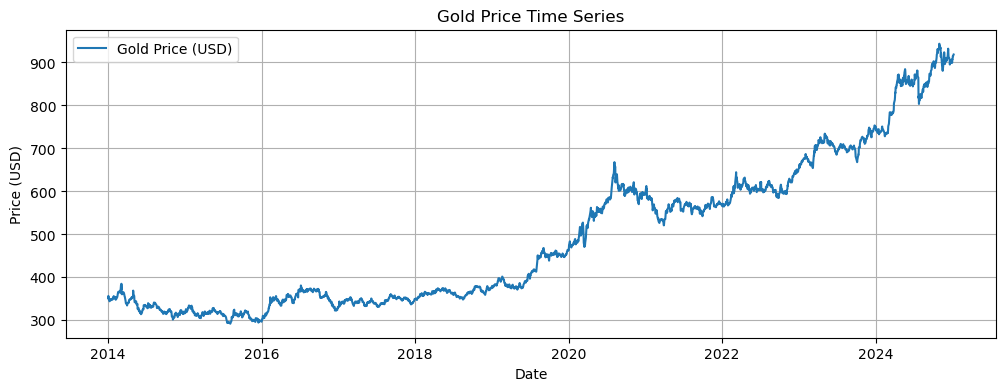

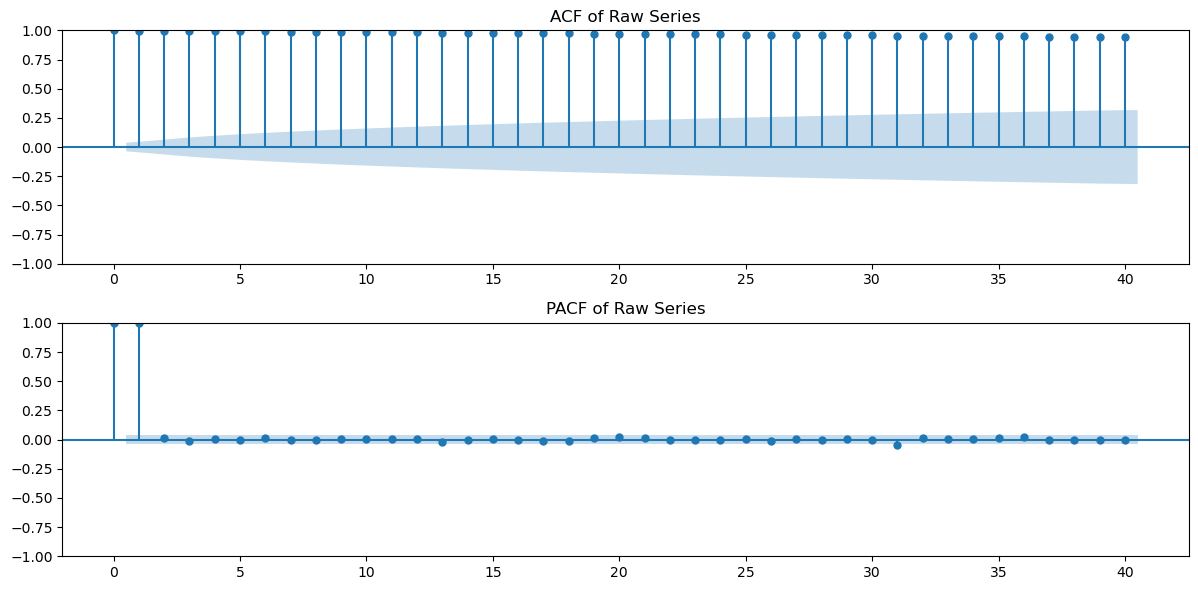

ADF Statistic: 1.3429313019488351
p-value: 0.9968388192662114
Critical Value (1%): -3.432650601050801
Critical Value (5%): -2.8625564475120617
Critical Value (10%): -2.567311085183206


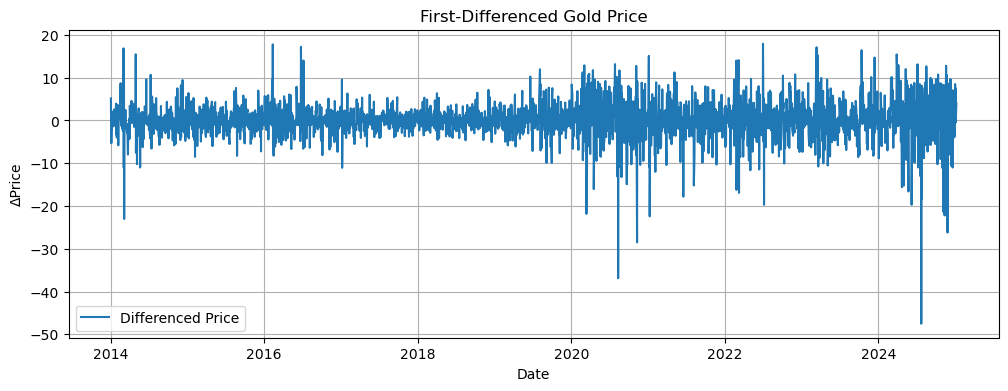

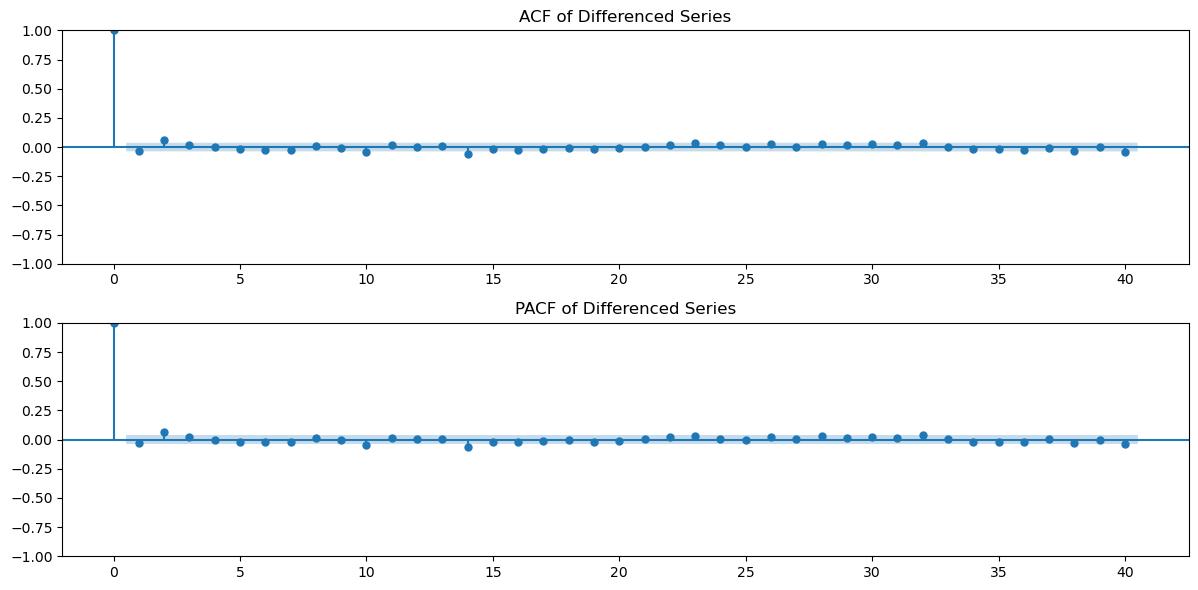

ADF Statistic (Differenced): -35.96965901844824
p-value: 0.0
Critical Value (1%): -3.432650601050801
Critical Value (5%): -2.8625564475120617
Critical Value (10%): -2.567311085183206


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# 1. Reconstruct time series from df_usd
df_usd = df_usd.sort_values('Date').reset_index(drop=True)
df_usd['Price'] = prices  # Ensure alignment
df_usd['Date'] = pd.to_datetime(df_usd['Date'])
df_usd.set_index('Date', inplace=True)

# 2. Plot raw gold price series
plt.figure(figsize=(12, 4))
plt.plot(df_usd['Price'], label='Gold Price (USD)')
plt.title('Gold Price Time Series')
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.grid(True)
plt.legend()
plt.show()

# 3. ACF and PACF of raw series
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(df_usd['Price'], ax=ax[0], lags=40)
plot_pacf(df_usd['Price'], ax=ax[1], lags=40)
ax[0].set_title('ACF of Raw Series')
ax[1].set_title('PACF of Raw Series')
plt.tight_layout()
plt.show()

# 4. Augmented Dickey-Fuller test on raw series
adf_result = adfuller(df_usd['Price'])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {value}")

# 5. First differencing (if needed)
df_usd['Price_diff'] = df_usd['Price'].diff()
df_diff = df_usd.dropna()

# 6. Plot differenced series
plt.figure(figsize=(12, 4))
plt.plot(df_diff['Price_diff'], label='Differenced Price')
plt.title('First-Differenced Gold Price')
plt.ylabel('ΔPrice')
plt.xlabel('Date')
plt.grid(True)
plt.legend()
plt.show()

# 7. ACF/PACF of differenced series
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(df_diff['Price_diff'], ax=ax[0], lags=40)
plot_pacf(df_diff['Price_diff'], ax=ax[1], lags=40)
ax[0].set_title('ACF of Differenced Series')
ax[1].set_title('PACF of Differenced Series')
plt.tight_layout()
plt.show()

# 8. ADF test on differenced series
adf_result_diff = adfuller(df_diff['Price_diff'])
print("ADF Statistic (Differenced):", adf_result_diff[0])
print("p-value:", adf_result_diff[1])
for key, value in adf_result_diff[4].items():
    print(f"Critical Value ({key}): {value}")


The data wasn't passing the ADF test meaning it was not likely stationary. Once I performed a first diff on the target column the time series data now passed the ADF test and should be ready for some forecasting.

However, because AR focuses only on previous values the forecasted line is probably going to be flat in comparison to the actual trend. Since the data is seasonl there may be a need to use something like SARIMAX with exogenous regressors to capture the actual trend.

In the first differenced data I want to try an ARIMA model for fun because the data tails off on both so there AR(1) and MA(1) is applicable.

In [6]:
import numpy as np
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def fit_ar_models_simple(df_usd, train_split=0.8):
    # --- STEP 1: Sort by date and prepare ---
    df_sorted = df_usd.sort_values('Date').reset_index(drop=True)
    prices = df_sorted['Price'].values
    dates = df_sorted['Date'].values
    
    # --- STEP 2: Split train/test BEFORE differencing ---
    train_size = int(len(prices) * train_split)
    train_prices = prices[:train_size]
    test_prices = prices[train_size:]
    train_dates = dates[:train_size]
    test_dates = dates[train_size:]
    
    print("="*60)
    print("DATA SUMMARY")
    print("="*60)
    print(f"Total observations: {len(prices)}")
    print(f"Training set: {len(train_prices)} observations")
    print(f"Test set: {len(test_prices)} observations")
    print(f"Date range: {dates[0]} to {dates[-1]}")

    # --- STEP 3: Difference only the training data ---
    train_diff = pd.Series(train_prices).diff().dropna()

    # --- STEP 4: Fit AR(1) model on differenced data ---
    print("\n" + "="*60)
    print("FITTING AR(1) MODEL ON DIFFERENCED TRAINING DATA")
    print("="*60)
    ar1_model = AutoReg(train_diff, lags=1, trend='ct')
    ar1_fitted = ar1_model.fit()
    print(ar1_fitted.summary())

    # --- STEP 5: Forecast differenced values for the test period ---
    n_forecast = len(test_prices)
    forecast_diff = ar1_fitted.forecast(steps=n_forecast)

    # --- STEP 6: Reverse differencing to get forecasted prices ---
    last_train_price = train_prices[-1]
    forecast_prices = []
    for diff_val in forecast_diff:
        next_price = last_train_price + diff_val
        forecast_prices.append(next_price)
        last_train_price = next_price  # accumulate
    forecast_prices = np.array(forecast_prices)

    # --- STEP 7: Evaluate performance ---
    mse_ar1 = mean_squared_error(test_prices, forecast_prices)

    print("\n" + "="*60)
    print("MODEL PERFORMANCE")
    print("="*60)
    print(f"AIC: {ar1_fitted.aic:.2f}")
    print(f"BIC: {ar1_fitted.bic:.2f}")
    print(f"Test MSE: {mse_ar1:.4f}")
    print(f"Test RMSE: {np.sqrt(mse_ar1):.4f}")

    # --- STEP 8: Return results ---
    results = {
        'dates': dates,
        'prices': prices,
        'train_dates': train_dates,
        'test_dates': test_dates,
        'train_prices': train_prices,
        'test_prices': test_prices,
        'train_diff': train_diff,
        'forecast_diff': forecast_diff,
        'forecast_prices': forecast_prices,
        'ar1_fitted': ar1_fitted,
        'mse_ar1': mse_ar1,
    }
    return results


def plot_results_simple(results):
    plt.figure(figsize=(14, 8))
    plt.plot(results['dates'], results['prices'], 
             label='Actual Prices', color='black', linewidth=1.5, alpha=0.7)
    plt.plot(results['test_dates'], results['forecast_prices'], 
             label='AR(1) Forecast', color='red', linestyle='--', linewidth=2)
    plt.axvline(x=results['train_dates'][-1], color='gray', linestyle=':', linewidth=2, label='Train/Test Split')
    
    plt.title(f"AR(1) Forecast - Test RMSE: {np.sqrt(results['mse_ar1']):.2f}", fontsize=14, fontweight='bold')
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()



In [17]:
# ARIMA version...
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

def fit_arima_model_auto(df_usd, train_split=0.8):
    # --- STEP 1: Sort by date and prepare ---
    df_sorted = df_usd.sort_values('Date').reset_index(drop=True)
    prices = df_sorted['Price'].values
    dates = df_sorted['Date'].values

    # --- STEP 2: Split train/test BEFORE differencing ---
    train_size = int(len(prices) * train_split)
    train_prices = prices[:train_size]
    test_prices = prices[train_size:]
    train_dates = dates[:train_size]
    test_dates = dates[train_size:]

    print("="*60)
    print("DATA SUMMARY")
    print("="*60)
    print(f"Total observations: {len(prices)}")
    print(f"Training set: {len(train_prices)} observations")
    print(f"Test set: {len(test_prices)} observations")
    print(f"Date range: {dates[0]} to {dates[-1]}")

    # --- STEP 3: Automatically find best ARIMA(p,d,q) ---
    print("\n" + "="*60)
    print("AUTO-ARIMA MODEL SELECTION")
    print("="*60)
    auto_model = pm.auto_arima(
        train_prices,
        start_p=0, start_q=0,
        max_p=5, max_q=5,
        d=None,           # let it choose differencing
        seasonal=False,   # no seasonality
        stepwise=True,
        trace=True,
        error_action='ignore',
        suppress_warnings=True
    )

    print("\nBest ARIMA order found:", auto_model.order)

    # --- STEP 4: Fit final ARIMA model ---
    best_order = auto_model.order
    arima_model = ARIMA(train_prices, order=best_order)
    arima_fitted = arima_model.fit()
    print(arima_fitted.summary())

    # --- STEP 5: Forecast for the test period ---
    n_forecast = len(test_prices)
    forecast_result = arima_fitted.get_forecast(steps=n_forecast)
    forecast_prices = forecast_result.predicted_mean
    conf_int = forecast_result.conf_int(alpha=0.05)

    # --- STEP 6: Evaluate performance ---
    mse = mean_squared_error(test_prices, forecast_prices)
    rmse = np.sqrt(mse)

    print("\n" + "="*60)
    print("MODEL PERFORMANCE")
    print("="*60)
    print(f"AIC: {arima_fitted.aic:.2f}")
    print(f"BIC: {arima_fitted.bic:.2f}")
    print(f"Test MSE: {mse:.4f}")
    print(f"Test RMSE: {rmse:.4f}")

    # --- STEP 7: Package results ---
    results = {
        'dates': dates,
        'prices': prices,
        'train_dates': train_dates,
        'test_dates': test_dates,
        'train_prices': train_prices,
        'test_prices': test_prices,
        'forecast_prices': forecast_prices,
        'conf_int': conf_int,
        'arima_fitted': arima_fitted,
        'order': best_order,
        'mse_arima': mse,
        'rmse_arima': rmse,
    }
    return results

def plot_results_arima(results):
    plt.figure(figsize=(14, 8))
    plt.plot(results['dates'], results['prices'], 
             label='Actual Prices', color='black', linewidth=1.5, alpha=0.7)
    plt.plot(results['test_dates'], results['forecast_prices'], 
             label=f"ARIMA{results['order']} Forecast", color='blue', linestyle='--', linewidth=2)

    # Handle conf_int as either DataFrame or NumPy array
    conf = results['conf_int']
    if isinstance(conf, np.ndarray):
        lower, upper = conf[:, 0], conf[:, 1]
    else:  # DataFrame
        lower, upper = conf.iloc[:, 0], conf.iloc[:, 1]

    plt.fill_between(results['test_dates'], lower, upper,
                     color='blue', alpha=0.2, label='95% Confidence Interval')

    plt.axvline(x=results['train_dates'][-1], color='gray', linestyle=':', linewidth=2, label='Train/Test Split')
    plt.title(f"ARIMA{results['order']} Forecast - Test RMSE: {results['rmse_arima']:.2f}", fontsize=14, fontweight='bold')
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


In [8]:
# Helper function to fit ar models using price.
def fit_ar_models_optimal_no_first_diff(df_usd, max_lags=20, train_split=0.8):
    """
    Fit AR(1) and AR(optimal) models to gold price data
    
    Parameters:
    -----------
    df_usd : DataFrame with USD prices
    max_lags : maximum lags to consider for optimal model
    train_split : proportion of data for training
    
    Returns:
    --------
    Dictionary with models, predictions, and metrics
    """
    # Sort by date and prepare data
    df_sorted = df_usd.sort_values('Date').reset_index(drop=True) # very important for time series.
    prices = df_sorted['Price'].values
    dates = df_sorted['Date'].values
    
    # Split into train and test
    train_size = int(len(prices) * train_split)
    train_data = prices[:train_size]
    test_data = prices[train_size:]
    train_dates = dates[:train_size]
    test_dates = dates[train_size:]
    
    print("="*60)
    print("DATA SUMMARY")
    print("="*60)
    print(f"Total observations: {len(prices)}")
    print(f"Training set: {len(train_data)} observations")
    print(f"Test set: {len(test_data)} observations")
    print(f"Date range: {dates[0]} to {dates[-1]}")
    
    # Find optimal lag order using AIC and BIC
    print("\n" + "="*60)
    print("SELECTING OPTIMAL LAG ORDER")
    print("="*60)
    
    selection = ar_select_order(train_data, maxlag=max_lags, ic='aic')
    optimal_lag_aic = selection.ar_lags[-1] if len(selection.ar_lags) > 0 else 1
    
    selection_bic = ar_select_order(train_data, maxlag=max_lags, ic='bic')
    optimal_lag_bic = selection_bic.ar_lags[-1] if len(selection_bic.ar_lags) > 0 else 1
    
    print(f"Optimal lag by AIC: {optimal_lag_aic}")
    print(f"Optimal lag by BIC: {optimal_lag_bic}")
    
    if optimal_lag_aic == optimal_lag_bic:
        print(f"✓ AIC and BIC agree on optimal lag: {optimal_lag_aic}")
    else:
        print(f"✗ AIC and BIC disagree (AIC: {optimal_lag_aic}, BIC: {optimal_lag_bic})")
        print(f"  Using AIC selection: {optimal_lag_aic}")
    
    optimal_lag = optimal_lag_aic
    
    # Fit AR(1) model
    print("\n" + "="*60)
    print("FITTING AR(1) MODEL")
    print("="*60)
    ar1_model = AutoReg(train_data, lags=1, trend='ct')
    ar1_fitted = ar1_model.fit()
    print(ar1_fitted.summary())
    
    # Fit AR(optimal) model
    print("\n" + "="*60)
    print(f"FITTING AR({optimal_lag}) MODEL")
    print("="*60)
    ar_opt_model = AutoReg(train_data, lags=optimal_lag, trend='ct')
    ar_opt_fitted = ar_opt_model.fit()
    print(ar_opt_fitted.summary())
    
    # Make predictions on test set
    ar1_predictions = ar1_fitted.predict(start=len(train_data), 
                                         end=len(train_data) + len(test_data) - 1)
    ar_opt_predictions = ar_opt_fitted.predict(start=len(train_data), 
                                               end=len(train_data) + len(test_data) - 1)
    
    # Calculate MSE
    mse_ar1 = mean_squared_error(test_data, ar1_predictions)
    mse_ar_opt = mean_squared_error(test_data, ar_opt_predictions)
    
    print("\n" + "="*60)
    print("MODEL COMPARISON")
    print("="*60)
    print(f"AR(1) Model:")
    print(f"  AIC: {ar1_fitted.aic:.2f}")
    print(f"  BIC: {ar1_fitted.bic:.2f}")
    print(f"  Test MSE: {mse_ar1:.4f}")
    print(f"  Test RMSE: {np.sqrt(mse_ar1):.4f}")
    
    print(f"\nAR({optimal_lag}) Model:")
    print(f"  AIC: {ar_opt_fitted.aic:.2f}")
    print(f"  BIC: {ar_opt_fitted.bic:.2f}")
    print(f"  Test MSE: {mse_ar_opt:.4f}")
    print(f"  Test RMSE: {np.sqrt(mse_ar_opt):.4f}")
    
    # Return results
    results = {
        'dates': dates,
        'prices': prices,
        'train_dates': train_dates,
        'test_dates': test_dates,
        'train_data': train_data,
        'test_data': test_data,
        'ar1_fitted': ar1_fitted,
        'ar_opt_fitted': ar_opt_fitted,
        'ar1_predictions': ar1_predictions,
        'ar_opt_predictions': ar_opt_predictions,
        'optimal_lag_aic': optimal_lag_aic,
        'optimal_lag_bic': optimal_lag_bic,
        'optimal_lag': optimal_lag,
        'mse_ar1': mse_ar1,
        'mse_ar_opt': mse_ar_opt
    }
    
    return results

# Step 3: Visualize results
def plot_results_optimal_first_diff(results):
    """Create time series plots comparing models"""
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot 1: AR(1) Model
    ax1 = axes[0]
    ax1.plot(results['dates'], results['prices'], 
             label='Original Data', color='black', linewidth=1.5, alpha=0.7)
    ax1.plot(results['test_dates'], results['ar1_predictions'], 
             label='AR(1) Predictions', color='red', linewidth=2, linestyle='--')
    ax1.axvline(x=results['train_dates'][-1], color='gray', 
                linestyle=':', linewidth=2, label='Train/Test Split')
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Gold Price (USD)', fontsize=12)
    ax1.set_title(f'AR(1) Model - Test RMSE: ${np.sqrt(results["mse_ar1"]):.2f}', 
                  fontsize=14, fontweight='bold')
    ax1.legend(loc='best', fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: AR(optimal) Model
    ax2 = axes[1]
    ax2.plot(results['dates'], results['prices'], 
             label='Original Data', color='black', linewidth=1.5, alpha=0.7)
    ax2.plot(results['test_dates'], results['ar_opt_predictions'], 
             label=f'AR({results["optimal_lag"]}) Predictions', 
             color='blue', linewidth=2, linestyle='--')
    ax2.axvline(x=results['train_dates'][-1], color='gray', 
                linestyle=':', linewidth=2, label='Train/Test Split')
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Gold Price (USD)', fontsize=12)
    ax2.set_title(f'AR({results["optimal_lag"]}) Model - Test RMSE: ${np.sqrt(results["mse_ar_opt"]):.2f}', 
                  fontsize=14, fontweight='bold')
    ax2.legend(loc='best', fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print final comparison
    print("\n" + "="*60)
    print("FINAL SUMMARY")
    print("="*60)
    if results['optimal_lag_aic'] == results['optimal_lag_bic']:
        print(f"✓ AIC and BIC both selected {results['optimal_lag']} lags")
    else:
        print(f"✗ AIC selected {results['optimal_lag_aic']} lags, BIC selected {results['optimal_lag_bic']} lags")



In [19]:
# SARIMAX version
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def fit_sarimax_model(df_usd, train_split=0.8, order=(1,1,1), seasonal_order=(0,0,0,0)):
    # --- STEP 1: Sort by date and prepare ---
    df_sorted = df_usd.sort_values('Date').reset_index(drop=True)
    prices = df_sorted['Price'].values
    dates = df_sorted['Date'].values

    # --- STEP 2: Split train/test ---
    train_size = int(len(prices) * train_split)
    train_prices = prices[:train_size]
    test_prices = prices[train_size:]
    train_dates = dates[:train_size]
    test_dates = dates[train_size:]

    print("="*60)
    print("DATA SUMMARY")
    print("="*60)
    print(f"Total observations: {len(prices)}")
    print(f"Training set: {len(train_prices)} observations")
    print(f"Test set: {len(test_prices)} observations")
    print(f"Date range: {dates[0]} to {dates[-1]}")

    # --- STEP 3: Fit SARIMAX model ---
    print("\n" + "="*60)
    print("FITTING SARIMAX MODEL")
    print("="*60)
    sarimax_model = SARIMAX(train_prices, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    sarimax_fitted = sarimax_model.fit(disp=False)
    print(sarimax_fitted.summary())

    # --- STEP 4: Forecast future prices ---
    n_forecast = len(test_prices)
    forecast_prices = sarimax_fitted.forecast(steps=n_forecast)

    # --- STEP 5: Evaluate performance ---
    mse_sarimax = mean_squared_error(test_prices, forecast_prices)

    print("\n" + "="*60)
    print("MODEL PERFORMANCE")
    print("="*60)
    print(f"AIC: {sarimax_fitted.aic:.2f}")
    print(f"BIC: {sarimax_fitted.bic:.2f}")
    print(f"Test MSE: {mse_sarimax:.4f}")
    print(f"Test RMSE: {np.sqrt(mse_sarimax):.4f}")

    # --- STEP 6: Return results ---
    results = {
        'dates': dates,
        'prices': prices,
        'train_dates': train_dates,
        'test_dates': test_dates,
        'train_prices': train_prices,
        'test_prices': test_prices,
        'forecast_prices': forecast_prices,
        'sarimax_fitted': sarimax_fitted,
        'mse_sarimax': mse_sarimax,
    }
    return results


def plot_results_sarimax(results):
    plt.figure(figsize=(14, 8))
    plt.plot(results['dates'], results['prices'], 
             label='Actual Prices', color='black', linewidth=1.5, alpha=0.7)
    plt.plot(results['test_dates'], results['forecast_prices'], 
             label='SARIMAX Forecast', color='blue', linestyle='--', linewidth=2)
    plt.axvline(x=results['train_dates'][-1], color='gray', linestyle=':', linewidth=2, label='Train/Test Split')
    
    plt.title(f"SARIMAX Forecast - Test RMSE: {np.sqrt(results['mse_sarimax']):.2f}", fontsize=14, fontweight='bold')
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


Conversion complete using rate: 1 USD = 84.0 INR
Total records converted: 2848

Price Statistics (USD):
  Mean: $490.74
  Min:  $292.20
  Max:  $943.54

First 5 rows:
        Date   Price    Open    High     Low
0 2025-01-06  918.44  920.35  923.12  911.25
1 2025-01-03  914.44  919.60  935.71  912.06
2 2025-01-02  914.87  914.87  914.87  914.87
3 2025-01-01  907.31  907.52  908.36  905.39
4 2024-12-31  907.52  900.95  916.31  899.67
DATA SUMMARY
Total observations: 2848
Training set: 2278 observations
Test set: 570 observations
Date range: 2014-01-01T00:00:00.000000000 to 2025-01-06T00:00:00.000000000

SELECTING OPTIMAL LAG ORDER
Optimal lag by AIC: 15
Optimal lag by BIC: 1
✗ AIC and BIC disagree (AIC: 15, BIC: 1)
  Using AIC selection: 15

FITTING AR(1) MODEL
                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 2278
Model:                     AutoReg(1)   Log Likelihood               -6

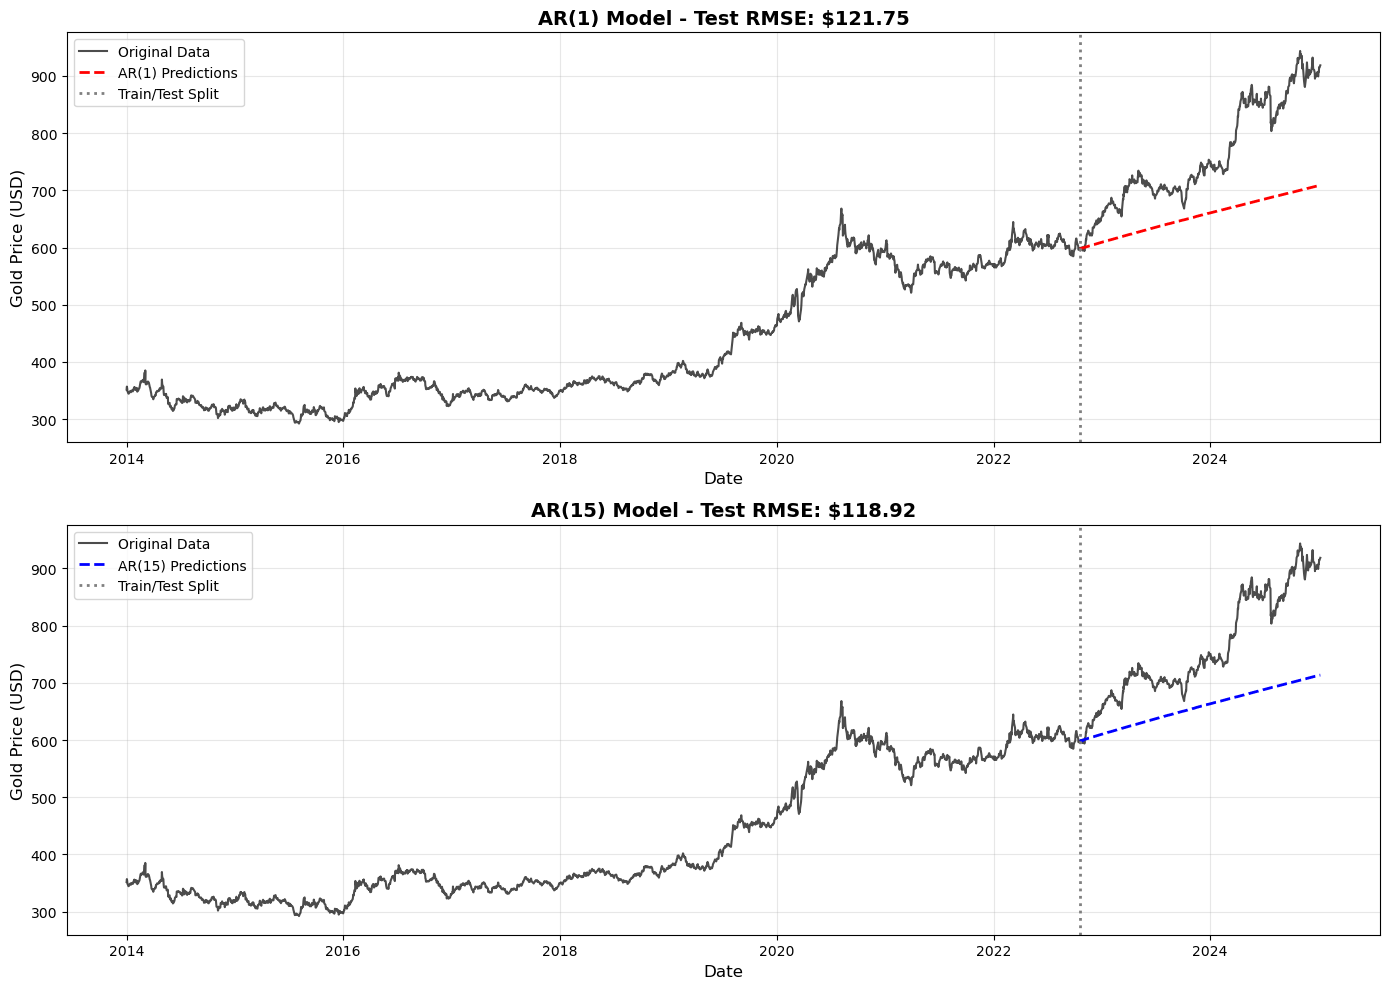


FINAL SUMMARY
✗ AIC selected 15 lags, BIC selected 1 lags


In [9]:
df_usd = convert_gold_prices_to_usd(df, usd_inr_rate=84.0)

results = fit_ar_models_optimal_no_first_diff(df_usd, max_lags=20, train_split=0.8)

plot_results_optimal_first_diff(results)

It did awful. Gonna try again with the first diff.
Interestingly the forecasted line is straight in this 0 differenced model. The RMSE improves slightly when using a higher AR(15) but not by much.

Conversion complete using rate: 1 USD = 84.0 INR
Total records converted: 2848

Price Statistics (USD):
  Mean: $490.74
  Min:  $292.20
  Max:  $943.54

First 5 rows:
        Date   Price    Open    High     Low
0 2025-01-06  918.44  920.35  923.12  911.25
1 2025-01-03  914.44  919.60  935.71  912.06
2 2025-01-02  914.87  914.87  914.87  914.87
3 2025-01-01  907.31  907.52  908.36  905.39
4 2024-12-31  907.52  900.95  916.31  899.67
DATA SUMMARY
Total observations: 2848
Training set: 2278 observations
Test set: 570 observations
Date range: 2014-01-01T00:00:00.000000000 to 2025-01-06T00:00:00.000000000

FITTING AR(1) MODEL ON DIFFERENCED TRAINING DATA
                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 2277
Model:                     AutoReg(1)   Log Likelihood               -6303.828
Method:               Conditional MLE   S.D. of innovations              3.860
Date:                Mon,

c:\Users\ianta\anaconda3\envs\cuda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ianta\anaconda3\envs\cuda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ianta\anaconda3\envs\cuda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


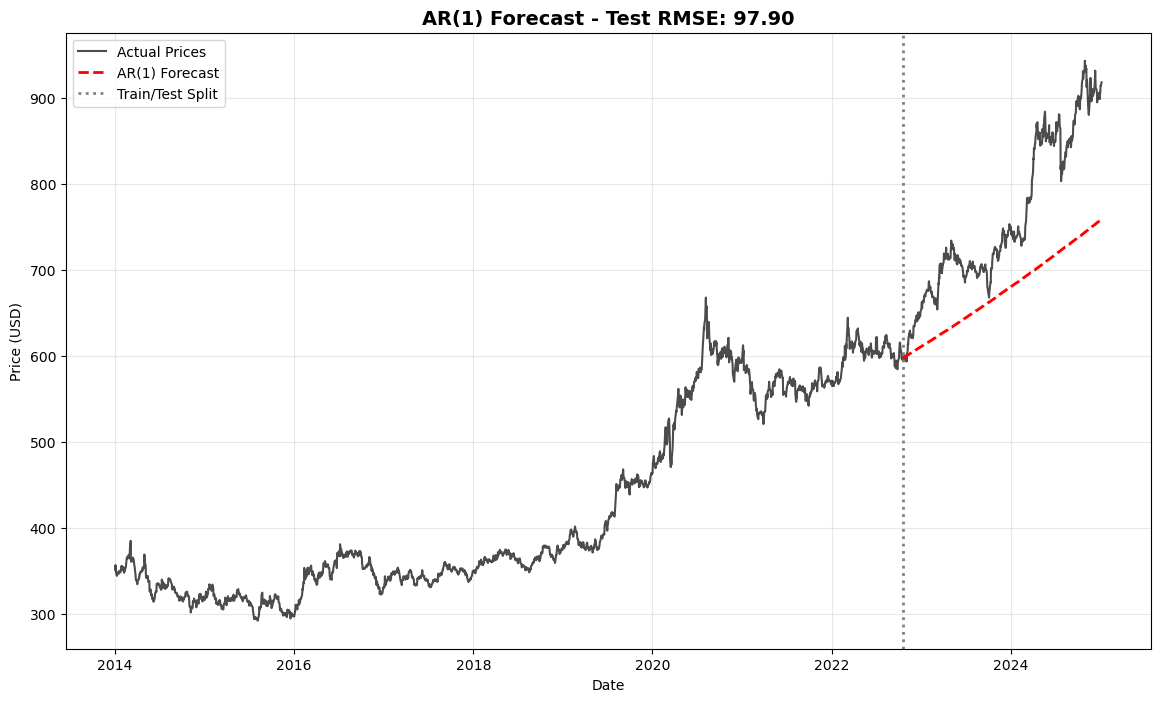

In [11]:
# df_usd['Price_diff'] = df_usd['Price'].diff()
# df_diff = df_usd.dropna()
# df_usd = df_usd.dropna()

df_usd = convert_gold_prices_to_usd(df, usd_inr_rate=84.0)
df_usd.head(5)

results = fit_ar_models_simple(df_usd, train_split=0.8)

plot_results_simple(results)

The first differenced model with trend='ct' did much better than the original naive attempt, but the forecast is still not following the actual pattern.

Conversion complete using rate: 1 USD = 84.0 INR
Total records converted: 2848

Price Statistics (USD):
  Mean: $490.74
  Min:  $292.20
  Max:  $943.54

First 5 rows:
        Date   Price    Open    High     Low
0 2025-01-06  918.44  920.35  923.12  911.25
1 2025-01-03  914.44  919.60  935.71  912.06
2 2025-01-02  914.87  914.87  914.87  914.87
3 2025-01-01  907.31  907.52  908.36  905.39
4 2024-12-31  907.52  900.95  916.31  899.67
DATA SUMMARY
Total observations: 2848
Training set: 2278 observations
Test set: 570 observations
Date range: 2014-01-01T00:00:00.000000000 to 2025-01-06T00:00:00.000000000

AUTO-ARIMA MODEL SELECTION
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12624.199, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12621.026, Time=0.07 sec


c:\Users\ianta\anaconda3\envs\cuda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ianta\anaconda3\envs\cuda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ianta\anaconda3\envs\cuda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ianta\anaconda3\envs\cuda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ianta\anaconda3\envs\cuda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and w

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12621.347, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12623.974, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=12620.852, Time=0.10 sec


c:\Users\ianta\anaconda3\envs\cuda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ianta\anaconda3\envs\cuda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ianta\anaconda3\envs\cuda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=12621.365, Time=0.21 sec


c:\Users\ianta\anaconda3\envs\cuda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12624.013, Time=0.75 sec


c:\Users\ianta\anaconda3\envs\cuda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12622.120, Time=0.33 sec


c:\Users\ianta\anaconda3\envs\cuda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=12622.479, Time=0.56 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=12620.683, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=12620.974, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=12621.100, Time=0.10 sec


c:\Users\ianta\anaconda3\envs\cuda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ianta\anaconda3\envs\cuda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ianta\anaconda3\envs\cuda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ianta\anaconda3\envs\cuda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0]             : AIC=12624.454, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=12622.040, Time=0.13 sec


c:\Users\ianta\anaconda3\envs\cuda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ianta\anaconda3\envs\cuda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0]             : AIC=12622.228, Time=0.32 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 3.169 seconds

Best ARIMA order found: (2, 1, 0)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2278
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -6307.342
Date:                Mon, 03 Nov 2025   AIC                          12620.683
Time:                        11:17:22   BIC                          12637.875
Sample:                             0   HQIC                         12626.954
                               - 2278                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0454      0.01

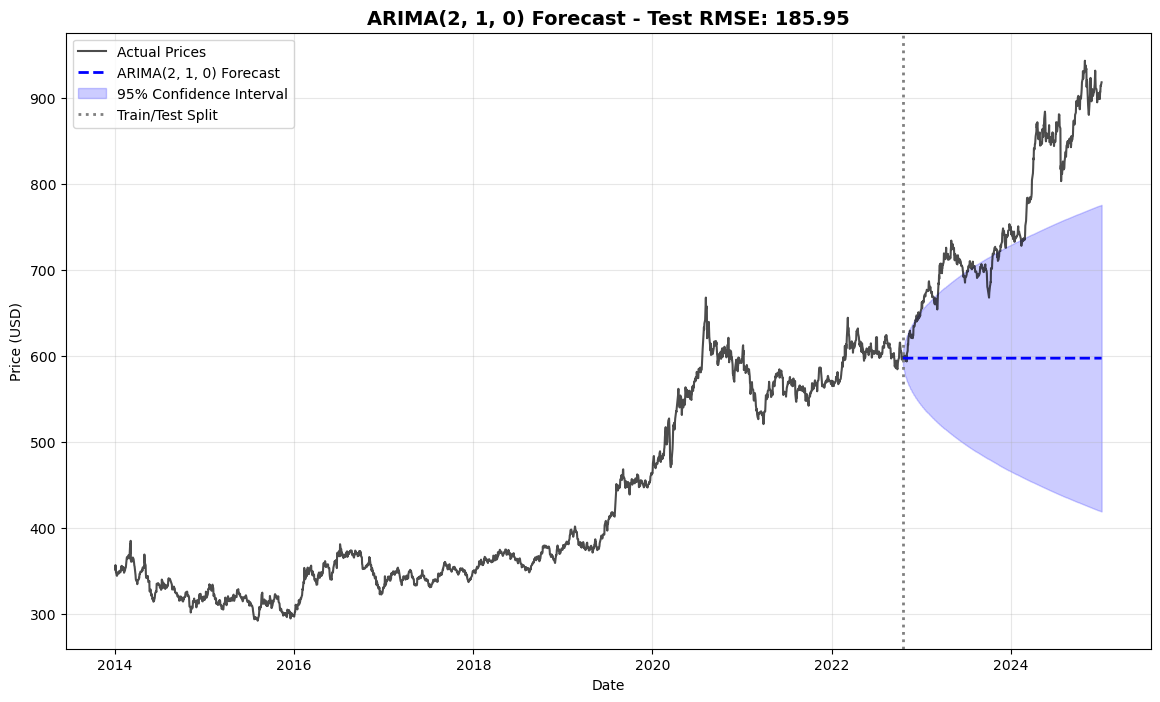

In [18]:
df_usd = convert_gold_prices_to_usd(df, usd_inr_rate=84.0)
df_usd.head(5)

results = fit_arima_model_auto(df_usd, train_split=0.8)

plot_results_arima(results)

I wanted to try arima since my forecast line isn't following the trend at all and it did even worse.

Conversion complete using rate: 1 USD = 84.0 INR
Total records converted: 2848

Price Statistics (USD):
  Mean: $490.74
  Min:  $292.20
  Max:  $943.54

First 5 rows:
        Date   Price    Open    High     Low
0 2025-01-06  918.44  920.35  923.12  911.25
1 2025-01-03  914.44  919.60  935.71  912.06
2 2025-01-02  914.87  914.87  914.87  914.87
3 2025-01-01  907.31  907.52  908.36  905.39
4 2024-12-31  907.52  900.95  916.31  899.67
DATA SUMMARY
Total observations: 2848
Training set: 2278 observations
Test set: 570 observations
Date range: 2014-01-01T00:00:00.000000000 to 2025-01-06T00:00:00.000000000

FITTING SARIMAX MODEL
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2278
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -6302.440
Date:                Mon, 03 Nov 2025   AIC                          12610.879
Time:                        11:30:18   BIC         

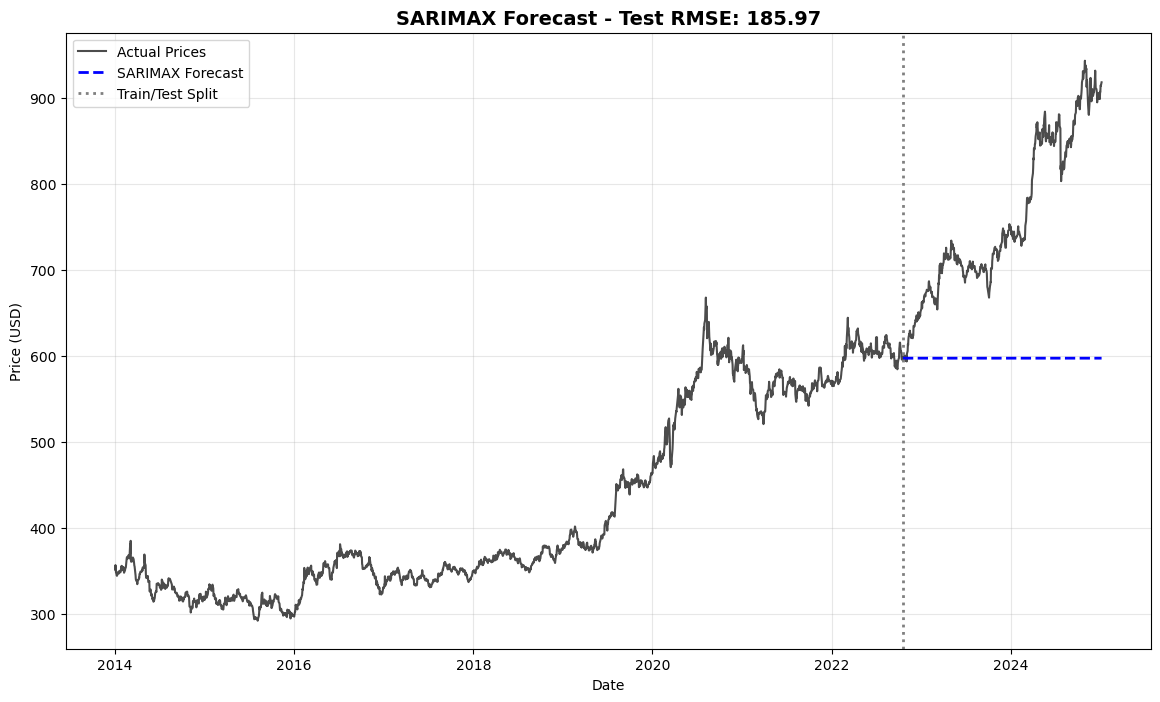

,Date,Price,Open,High,Low,Volume,Chg%
0,2025-01-06,918.44,920.35,923.12,911.25,27160,0.44
1,2025-01-03,914.44,919.60,935.71,912.06,60,-0.05
2,2025-01-02,914.87,914.87,914.87,914.87,0,0.83
3,2025-01-01,907.31,907.52,908.36,905.39,60,-0.02
4,2024-12-31,907.52,900.95,916.31,899.67,1920,0.95


In [21]:
df_usd = convert_gold_prices_to_usd(df, usd_inr_rate=84.0)
df_usd.head(5)

results = fit_sarimax_model(df_usd, train_split=0.8)

plot_results_sarimax(results)
df_usd.head(5)

Alright. So that probelm is that gold price is driven by a bunch of external variables. SO I really need to do this for short term windows because doing it for the entire 10 years is rough.

✅ Pros of Using AR(1) for Gold Price Forecasting
Simplicity and Speed: AR(1) is easy to implement and computationally efficient, making it ideal for quick baseline models.

Captures Short-Term Autocorrelation: Gold prices often exhibit short-term momentum or mean-reversion, which AR(1) can model effectively.

Useful for Stationary Segments: If gold prices are differenced to achieve stationarity, AR(1) can model the residual structure well.

Benchmarking Tool: Serves as a baseline to compare more complex models like SARIMA, GARCH, or machine learning approaches.

❌ Cons of Using AR(1) for Gold Price Forecasting
Ignores External Drivers: Gold prices are influenced by macroeconomic factors (e.g., inflation, interest rates, geopolitical events) that AR(1) cannot account for.

Fails to Capture Seasonality and Cycles: Gold may exhibit seasonal patterns or cyclical behavior that AR(1) is too simple to model.

Flat Forecasts: AR(1) often produces flat or linear forecasts, especially when the autoregressive coefficient is near 1 — which is common in financial time series.

Poor Long-Term Accuracy: Over a 10-year horizon, AR(1) lacks the flexibility to adapt to structural changes, regime shifts, or long-term trends in the gold market.

Sensitive to Non-Stationarity: Gold prices are typically non-stationary, requiring differencing or transformation before AR(1) can be applied — and even then, it may not capture the full dynamics.

<h3>(2) Hide the end of the data set and forecast the series using the different models. Decide which model you would use and explain why.</h3>

In [ ]:
# TODO 

<h3>(3) Add one other independent variable to the model and compare the forecasts of this updated model to the previous ones.</h3>

In [ ]:
# TODO

THIS MIGHT BE OBE!!! AWWWW SHIEEET.
THAT IS SO HILARIOUS LOL
i guess I learned a lot though....